# Chicago Crime Stats Project - Landon and Cooper

## 1. Import Necessary Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## 2. Load Data

In [3]:
df = pd.read_csv("chicago_crimes.csv", parse_dates=["Date"])
# Remove 2025, as it is not complete
df = df[df["Year"] < 2025]

## 3. Finding the Actual Trends

In [4]:
violent_types = {
    "HOMICIDE", "ASSAULT", "BATTERY",
    "CRIM SEXUAL ASSAULT", "ROBBERY", "ARSON"
}

df["Violent"] = df["Primary Type"].isin(violent_types).astype(int)

# Group by year and calculate proportions
violent_proportions = (
    df.groupby("Year")["Violent"]
    .mean()
    .reset_index(name="Proportion")
)

# Save to a DataFrame
print(violent_proportions)

    Year  Proportion
0   2001    0.301994
1   2002    0.303376
2   2003    0.290583
3   2004    0.286993
4   2005    0.285895
5   2006    0.279376
6   2007    0.283728
7   2008    0.282634
8   2009    0.279421
9   2010    0.279299
10  2011    0.276221
11  2012    0.282089
12  2013    0.279081
13  2014    0.283758
14  2015    0.294100
15  2016    0.310369
16  2017    0.308325
17  2018    0.305728
18  2019    0.305530
19  2020    0.325018
20  2021    0.334541
21  2022    0.299815
22  2023    0.300716
23  2024    0.309066


## 4. Graphing the Actual Trends

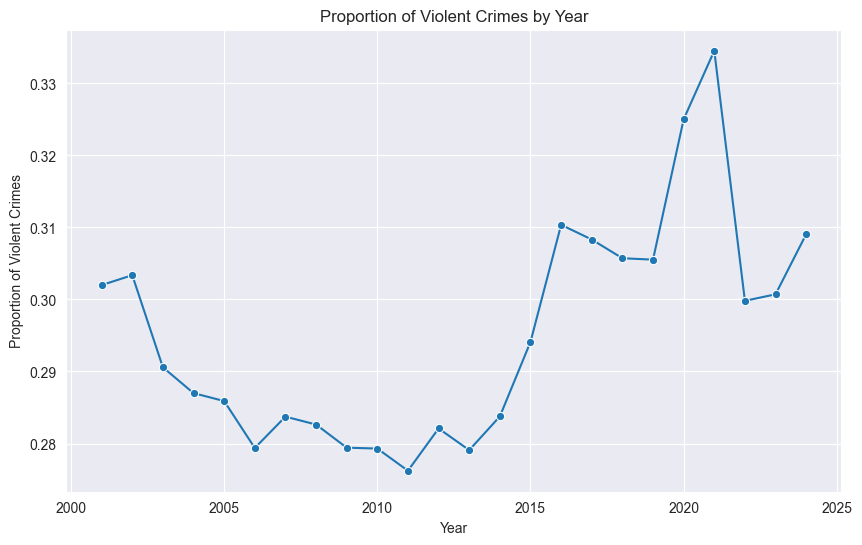

In [5]:
# Graph the proportions
plt.figure(figsize=(10, 6))
sns.lineplot(data=violent_proportions, x="Year", y="Proportion", marker="o")
plt.title("Proportion of Violent Crimes by Year")
plt.xlabel("Year")
plt.ylabel("Proportion of Violent Crimes")
plt.grid(True)
plt.show()

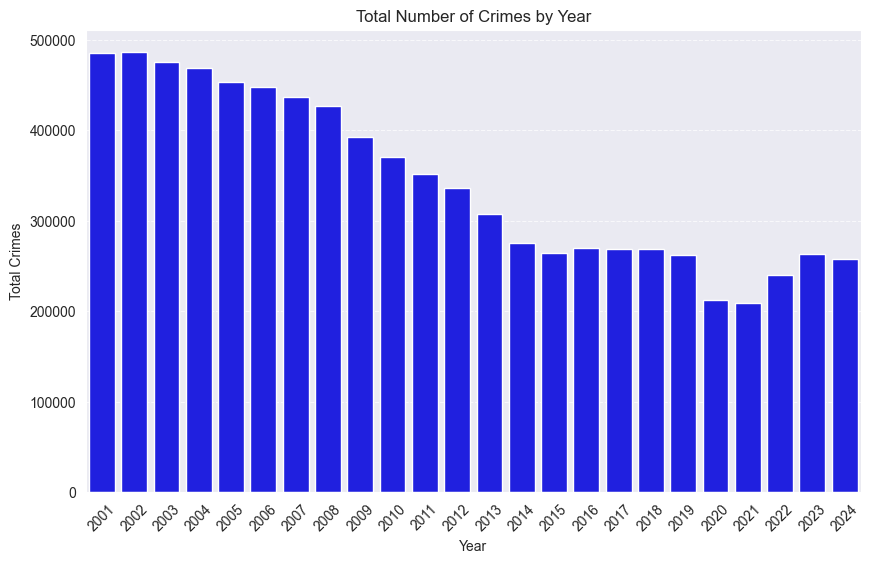

In [6]:
# Group by year and count total crimes
total_crimes_per_year = (
    df.groupby("Year")
    .size()
    .reset_index(name="Total Crimes")
)

# Graph the total number of crimes per year
plt.figure(figsize=(10, 6))
sns.barplot(data=total_crimes_per_year, x="Year", y="Total Crimes", color="blue")
plt.title("Total Number of Crimes by Year")
plt.xlabel("Year")
plt.ylabel("Total Crimes")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

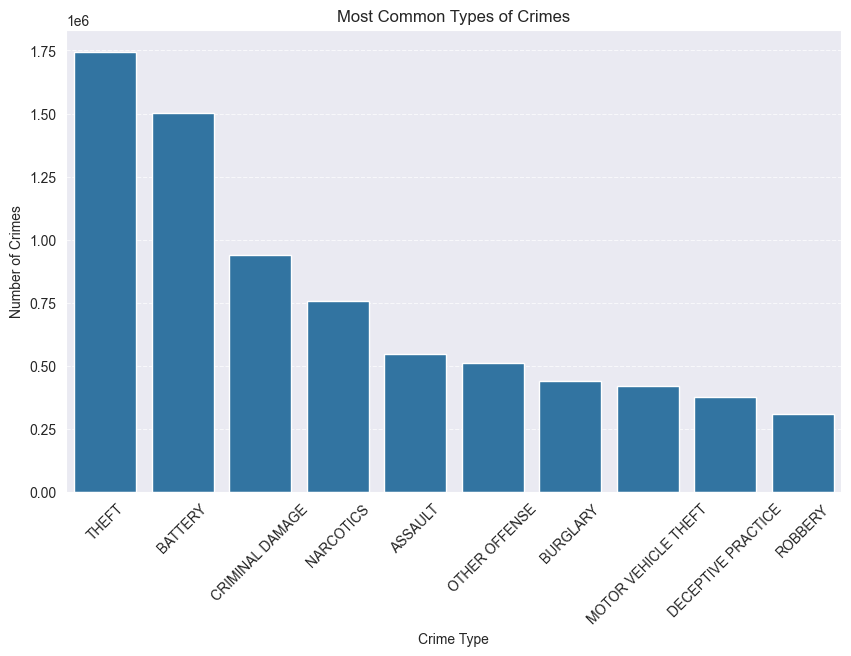

In [7]:
# Display types of crimes by most common
crime_types = df["Primary Type"].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=crime_types.index, y=crime_types.values)
plt.title("Most Common Types of Crimes")
plt.xlabel("Crime Type")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

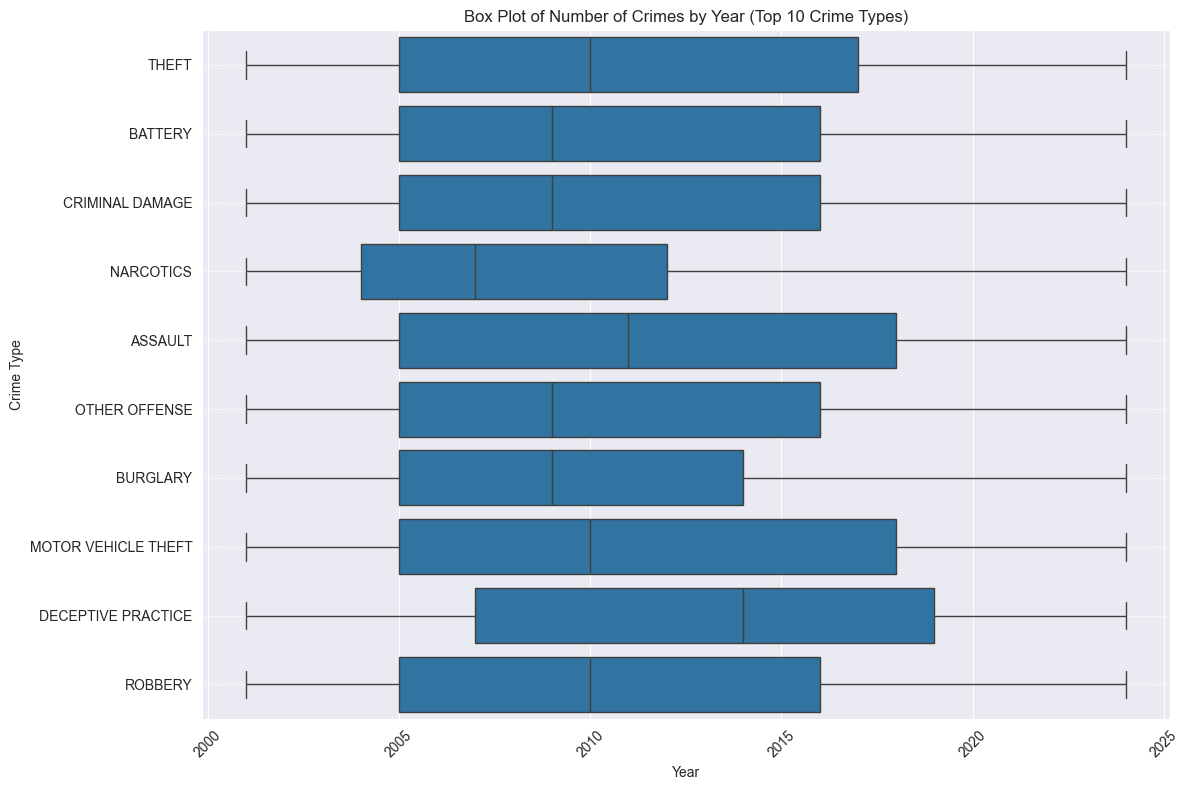

In [13]:
# Filter for the top 10 most common crime types
top_crime_types = df["Primary Type"].value_counts().head(10).index
filtered_df = df[df["Primary Type"].isin(top_crime_types)]

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_df, x="Year", y="Primary Type", order=top_crime_types)
plt.title("Box Plot of Number of Crimes by Year (Top 10 Crime Types)")
plt.xlabel("Year")
plt.ylabel("Crime Type")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Stratified Random Sampling

In [9]:
target_amount = 10000
seed = 20250417
sample = (
    df.groupby("Year", group_keys=False)
      .sample(n=target_amount, random_state=seed)
      .reset_index(drop=True)
)

## 6. Confidence Interval and Hypothesis Testing

In [10]:
# Perform a hypothesis test and confidence interval for the change in the proportion of violent crimes between 2001 and 2024
yearly_proportions = sample.groupby('Year')['Violent'].mean().reset_index()
yearly_proportions.rename(columns={'Violent': 'ProportionViolent'}, inplace=True)

# Calculate the difference in proportions
proportion_2001 = yearly_proportions[yearly_proportions['Year'] == 2001]['ProportionViolent'].values[0]
proportion_2024 = yearly_proportions[yearly_proportions['Year'] == 2024]['ProportionViolent'].values[0]
difference = proportion_2024 - proportion_2001

# Calculate the standard error
n_2001 = sample[sample['Year'] == 2001].shape[0]
n_2024 = sample[sample['Year'] == 2024].shape[0]
se_2001 = proportion_2001 * (1 - proportion_2001) / n_2001
se_2024 = proportion_2024 * (1 - proportion_2024) / n_2024
se_diff = (se_2001 + se_2024) ** 0.5

# Calculate the 95% confidence interval
z_score = 1.96  # for 95% CI
ci_lower = difference - z_score * se_diff
ci_upper = difference + z_score * se_diff

# Calculate the p-value for the hypothesis test
from scipy.stats import norm
z = difference / se_diff
p_value = 2 * (1 - norm.cdf(abs(z)))
# Display results
print(f"Difference in proportions (2024 - 2001): {difference:.4f}")
print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant change in the proportion of violent crimes.")
else:
    print("Fail to reject the null hypothesis: There is no significant change in the proportion of violent crimes.")

Difference in proportions (2024 - 2001): -0.0029
95% CI: (-0.0157, 0.0099)
p-value: 0.6565
Fail to reject the null hypothesis: There is no significant change in the proportion of violent crimes.


## 6. Linear Regression

In [11]:
# Center the Year variable
yearly_proportions['Year_Centered'] = yearly_proportions['Year'] - yearly_proportions['Year'].mean()

X = sm.add_constant(yearly_proportions['Year_Centered'])
y = yearly_proportions['ProportionViolent']
ols_model = sm.OLS(y, X).fit()

# Display the summary of the regression results
print("OLS Regression → ProportionViolent ~ Year")
print("-" * 40)
print(ols_model.summary())

# Extract key results below
slope = ols_model.params['Year_Centered']
intercept = ols_model.params['const']
p_value_slope = ols_model.pvalues['Year_Centered']
conf_int = ols_model.conf_int(alpha=0.05).loc['Year_Centered']

print("\n--- Summary ---")
print(f"Intercept α̂  : {intercept:.4f}")
print(f"Slope β̂ (Year_Centered): {slope:.6f}")
print(f"95% CI (Slope): ({conf_int[0]:.6f}, {conf_int[1]:.6f})")
print(f"p-value (Slope): {p_value_slope:.4g}")

if p_value_slope < 0.05:
    interpretation = "shows a statistically significant linear trend over 2001–2024."
else:
    interpretation = "does not show a statistically significant linear trend over 2001–2024."

print(f"\nResult: The annual proportion of violent crime {interpretation}")
print(f"On average, the proportion changed by {slope*100:.3f} percentage points per year.")

OLS Regression → ProportionViolent ~ Year
----------------------------------------
                            OLS Regression Results                            
Dep. Variable:      ProportionViolent   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     5.359
Date:                Sun, 27 Apr 2025   Prob (F-statistic):             0.0303
Time:                        22:10:53   Log-Likelihood:                 68.144
No. Observations:                  24   AIC:                            -132.3
Df Residuals:                      22   BIC:                            -129.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

## 7. Visualize Results

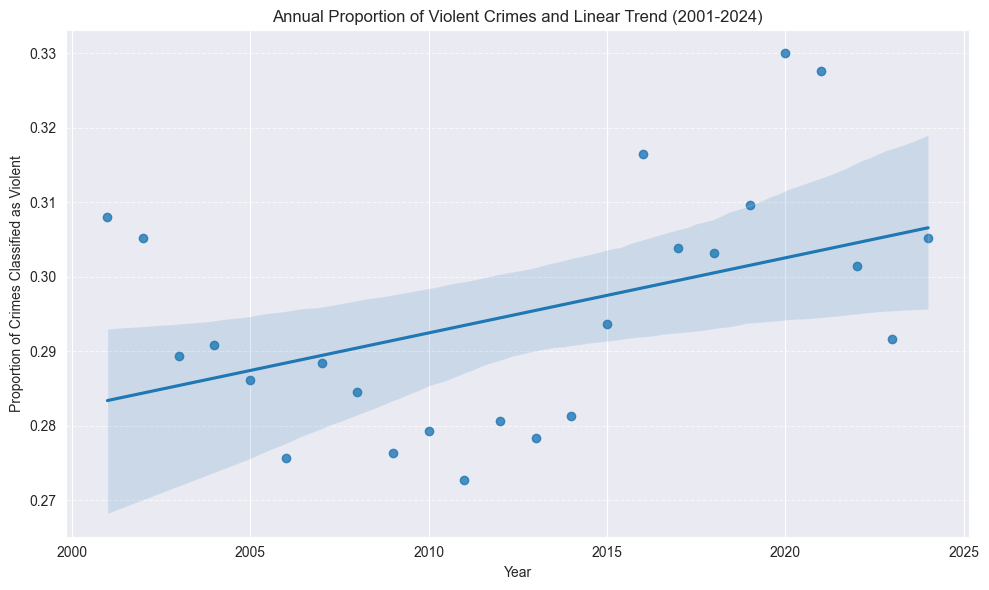

In [12]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Year', y='ProportionViolent', data=yearly_proportions, ci=95) # Show 95% CI on plot

plt.title('Annual Proportion of Violent Crimes and Linear Trend (2001-2024)')
plt.ylabel('Proportion of Crimes Classified as Violent')
plt.xlabel('Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()